# Prelude

We begin by importing the necessary libraries and defining useful functions. Caffe is assumed to be in a directory named _caffe_ inside of this diretory.

In [1]:
import os
import sys
import matplotlib

import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

from IPython.display import display, Math, Image
from sklearn.linear_model import LogisticRegression


%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [2]:
# Make sure that caffe is in the path
caffe_root = 'caffe/'
sys.path.insert(0, caffe_root + 'python')
import caffe

In [3]:
# A function to print latex in a more natural way within python
def math(message):
    scaped_chars = ' {}'
    message = message.split('$')
    for i in range(0, len(message), 2):
        for c in scaped_chars:
            message[i] = message[i].replace(c, '\\' + c)                                            
        message[i] = '\mathrm{' + message[i] + '}'
    return Math("".join(message))

# A function to print a table whithin python
def print_table(row_labels, col_labels, data):
    row_labels = map(str, row_labels)
    col_labels = map(str, col_labels)
    data = map(lambda row: map(str, row), data)
    
    row_span = max(map(len, row_labels))
    col_span = max(map(len, col_labels))
    
    print ' ' * row_span,
    for col in col_labels:
        print col.rjust(col_span),
    print
    for row, data_row in zip(row_labels, data):
        print row.ljust(row_span),
        for col in data_row:
            print col.rjust(col_span),
        print

        
def relative_error(x, y):
    if x == y == 0: return 0
    return abs(x - y) / max(abs(x), abs(y))

def squared_l2(x):
    return np.sum(x**2)

def compute_gradient(J, theta):
    epsilon = 0.0001

    gradient = np.zeros(theta.shape)
    for i in range(theta.shape[0]):
        theta_epsilon_plus = np.array(theta, dtype=np.float64)
        theta_epsilon_plus[i] = theta[i] + epsilon
        theta_epsilon_minus = np.array(theta, dtype=np.float64)
        theta_epsilon_minus[i] = theta[i] - epsilon

        gradient[i] = (J(theta_epsilon_plus)[0] - J(theta_epsilon_minus)[0]) / (2 * epsilon)

    return gradient

In [4]:
def load_MNIST_images(filename):
    """
    returns a 28x28x[number of MNIST images] matrix containing
    the raw MNIST images
    :param filename: input data file
    """
    with open(filename, "r") as f:
        magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)

        num_images = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        num_rows = np.fromfile(f, dtype=np.dtype('>i4'), count=1)
        num_cols = np.fromfile(f, dtype=np.dtype('>i4'), count=1)

        images = np.fromfile(f, dtype=np.ubyte)
        images = images.reshape((num_images, num_rows * num_cols)).transpose()
        images = images.astype(np.float64) / 255

        f.close()

        return images

def load_MNIST_labels(filename):
    """
    returns a [number of MNIST images]x1 matrix containing
    the labels for the MNIST images
    :param filename: input file with labels
    """
    with open(filename, 'r') as f:
        magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)

        num_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=1)

        labels = np.fromfile(f, dtype=np.ubyte)

        f.close()

        return labels
    
def display_network(A):
    opt_normalize = True
    opt_graycolor = True

    # Rescale
    A = A - np.average(A)

    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    n = np.ceil(np.sqrt(col))
    m = np.ceil(col / n)

    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))

    if not opt_graycolor:
        image *= 0.1

    k = 0
    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue

            clim = np.max(np.abs(A[:, k]))

            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1

    plt.imshow(image, cmap=matplotlib.cm.gray)

# Sample Neural Network

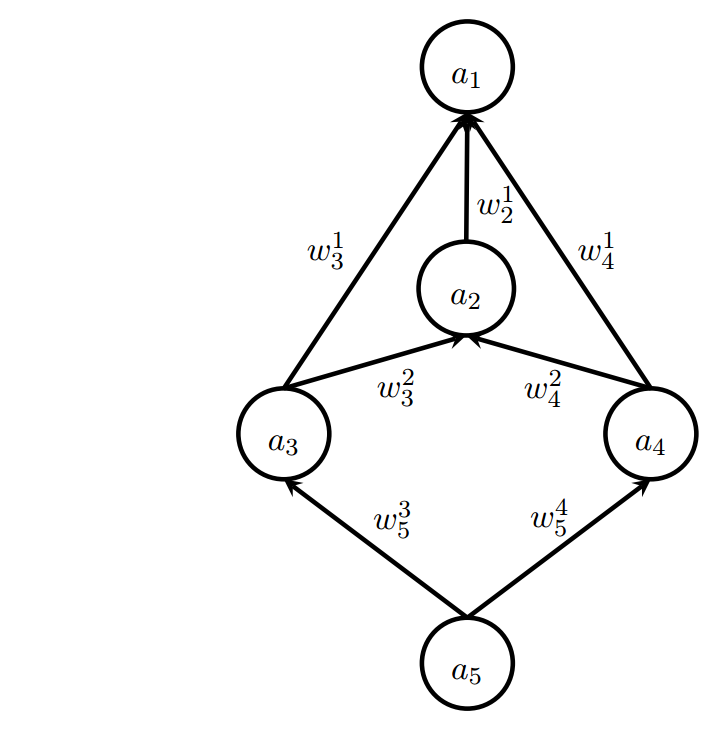

In [5]:
display(Image("network.png"))

The following is based in the network above, where $a_i = \sum_j w_j^i z_j$, $z_i=f_i(a_i)$ for $i=1,2,3,4$, $z_5=a_5$ is an input neuron and $f_2(x) = \mathrm{ReLU}(x)$ and $f_1(x) = f_3(x) = f_4(x) = \mathrm{sigmoid}(x) = \sigma(x)$. The cost function will be given by $\frac{1}{2}\Vert x - y\Vert_2^2$.

These functions, as well as their derivatives are implemented below.

In [6]:
def identity(x):
    return x
def didentity(x):
    return 1


def cost(y):
    return (lambda x: .5 * (x - y) ** 2)

def dcost(y):
    return (lambda x: x - y)


def relu(x):
    return x * (x > 0)

def drelu(x):
    return 1. * (x > 0)


def sigmoid(x):
    return 1/(1 + np.exp(-x))

def dsigmoid(x):
    s = sigmoid(x)
    return (1 - s) * s

And below is the implementation of the function that simulates the neuron described above

In [7]:
def evaluate_neural_network(W, x):
    f = [sigmoid, relu, sigmoid, sigmoid, identity]
    
    a = np.array([0, 0, 0, 0, x])
    z = np.array([0, 0, 0, 0, x])

    n = len(W)
    for i in range(n - 2, -1, -1):
        a[i] = np.dot(W.T[i], z)
        z[i] = f[i](a[i])
        
    return a, z

The cost function is $C(y, z_1) = \frac{1}{2}\Vert z_1 - y\Vert^2$. Note that $\frac{\partial C}{\partial z_1} = z_1 - y$.
Define the error value per neuron as $\delta_i = \frac{\partial C}{\partial a_i}$.

Since $z_1=\sigma(a_1)$, we obtain that: 
$$\delta_1 = \frac{\partial C}{\partial z_1}\frac{d z_1}{d a_1} = (a_1 - y)\sigma'(a_1)$$

Note that, due to the chain rule, we obtain that for $k>1$:
$$
\delta_k = \frac{\partial C}{\partial a_k} 
         = \sum_i \frac{\partial C}{\partial a_i} \frac{\partial a_i}{\partial a_k} 
         = \frac{d z_k}{d a_k} \sum_i \delta_i \frac{partial a_i}{\partial z_k} 
         = f_k'(a_k) \sum_i w_k^i \delta_i
$$ 

And so we have that:
$$
\delta_1 = (a_1 - y)\ \sigma'(a_1) \\
\delta_2 = \text{ReLU}'(a_2)\ w_2^1 \delta_1 \\
\delta_3 = \sigma'(a_3)\ \left(\delta_2 w_3^2 + \delta_1 w_3^1\right) \\
\delta_4 = \sigma'(a_4)\ \left(\delta_2 w_4^2 + \delta_1 w_4^1\right) \\
\delta_5 = \delta_2 w_5^4 + \delta_1 w_5^3
$$

Below is the function that computes $\delta_i$ for $i=1,\ldots,5$.

In [8]:
def calculate_error_values(W, x, y):
    a, z = evaluate_neural_network(W, x)
        
    df = [dsigmoid, drelu, dsigmoid, dsigmoid, didentity]
    da = np.array([dcost(y)(z[0]) * df[0](a[0]), 0, 0, 0, 0])
    
    n = len(W)
    for i in range(1, n):
        da[i] = np.dot(W[i], da) * df[i](a[i])
        
    return da


def calculate_error_values_test(W, x, y):
    f = [sigmoid, relu, sigmoid, sigmoid, identity]
    
    delta = .00001
    d = calculate_error_values(W, x, y)
    a, z = evaluate_neural_network(W, x)
    
    for i in range(5):        
        neuron_input = a[i]
        new_neuron_input = neuron_input + delta
        
        z_copy = np.copy(z)
        z_copy[i] = f[i](new_neuron_input)
                
        for j in range(i - 1, -1, -1):
            z_copy[j] = f[j](np.dot(W.T[j], z_copy))
            
        delta_cost = cost(y)(z_copy[0]) - cost(y)(z[0])
        assert(relative_error(delta_cost, delta * d[i]) < 1e-4)

In [9]:
W = np.array([[ 0.,   0.,   0.,   0.,   0.],
              [ 3.,   0.,   0.,   0.,   0.],
              [-4.,   1.,   0.,   0.,   0.],
              [-1.,  -3.,   0.,   0.,   0.],
              [ 0.,   0.,   2., -10.,   0.]])

calculate_error_values_test(W, 0., .5)
calculate_error_values_test(W, 1., .1)

display(math('For the weight matrix given by'))
print W

print

display(math('The output $z_i$ for each neuron when $x=0$ is:'))
print '\t', evaluate_neural_network(W, 0.)[1]
display(math('And the error $\delta_i$ when $x=0$ and $y=0.5$ is:'))
print '\t', calculate_error_values(W, 0., .5)

print

display(math('The output $z_i$ for each neuron when $x=1$ is:'))
print '\t', evaluate_neural_network(W, 1.)[1]
display(math('And the error $\delta_i$ when $x=1$ and $y=0.1$ is:'))
print '\t', calculate_error_values(W, 1., .1)


<IPython.core.display.Math object>

[[  0.   0.   0.   0.   0.]
 [  3.   0.   0.   0.   0.]
 [ -4.   1.   0.   0.   0.]
 [ -1.  -3.   0.   0.   0.]
 [  0.   0.   2. -10.   0.]]



<IPython.core.display.Math object>

	[ 0.076 -0.     0.5    0.5    0.   ]


<IPython.core.display.Math object>

	[-0.03  -0.     0.03   0.007 -0.015]



<IPython.core.display.Math object>

	[ 0.293  0.881  0.881  0.     1.   ]


<IPython.core.display.Math object>

	[ 0.04   0.12  -0.004 -0.    -0.008]


We now define a function to train the neural network using Stochastic Gradient Descent. 
The method was modified to make the step size vary according to the norm of the gradient and the number of iterations that have been made to improve it's convergence.

In [10]:
def train_neural_network(W_mask, W, xs, ys, max_iterations=200):
    n_samples = len(xs)
    iteration_count = 1
    
    errors = []
    
    while True:
        zs = np.array([evaluate_neural_network(W, x)[1]  for x in xs])
        
        error = 0
        for i in range(n_samples):
            error += cost(ys[i])(zs[i][0])
        
        errors.append(error)
        if iteration_count > max_iterations:
            break
        
        ds = np.array([calculate_error_values(W, xs[i], ys[i])  for i in range(n_samples)])
        
        zs = zs.reshape(n_samples, -1, 1)
        ds = ds.reshape(n_samples, 1, -1)
        
        # W_mask is used so that we select only the entries that are allowed by the network
        # i.e. we don't create new connections
        dW = W_mask * np.sum(np.array([np.dot(zs[i], ds[i])  for i in range(n_samples)]), axis=0)
        
        norm = .5 * squared_l2(dW)**.5        
        step_size = .1 / (norm * iteration_count**.3)
        # if iteration_count % 100 == 0:
        #     print "norm =", norm
        #     print "error =", error
        
        W += step_size * -dW
        iteration_count += 1
            
    return W, np.array(errors)

The network is trained for 5000 iterations using a sample seen on the given values. The evolution of the error as well as the final function is shown below.

[[ 0.    -0.     0.     0.    -0.   ]
 [-1.168  0.     0.    -0.    -0.   ]
 [-0.13  -8.093  0.     0.    -0.   ]
 [ 2.113 -5.17   0.     0.    -0.   ]
 [ 0.    -0.    -8.529 -1.031  0.   ]]
error:  0.0728426502388


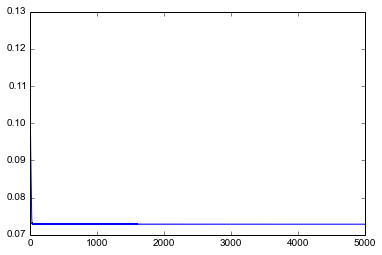

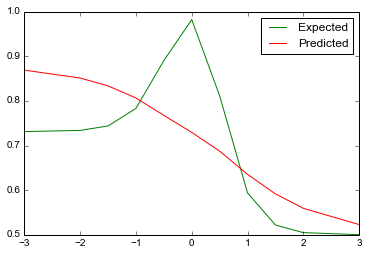

In [11]:
W_mask = 1. * (W != 0)

xs = np.array([   -3,    -2,  -1.5,    -1,   -.5,     0,    .5,      1,  1.5,     2,     3])
ys = np.array([.7312, .7339, .7438, .7832, .8903, .9820, .8114, .5937, .5219, .5049, .5002])

W0 = (20 * np.random.uniform(size=W_mask.shape) - 10) * W_mask
W_trained, errors = train_neural_network(W_mask, W0, xs, ys, 5000)
predicted_ys = np.array([evaluate_neural_network(W_trained, x)[1][0]  for x in xs])

print W_trained
print "error: ", errors[-1]
plt.plot(np.arange(len(errors)), errors)
plt.show()
plt.plot(xs, ys, 'g-', label='Expected')
plt.plot(xs, predicted_ys, 'r-', label='Predicted')
plt.legend()
plt.show()

We observed than on certain seeds, the method converges quickly, and that these seeds are common enough to look for them at random.
The network is trained on the samples using only 200 iterations, and if the error is less than a threshold, it is trained for another 5000.

One such seed is for example

```
W0 = np.array(
[[ 0.   ,  0.   , -0.  ,  -0.  ,   0.   ],
 [-0.561,  0.   ,  0.  ,  -0.  ,  -0.   ],
 [ 4.466,  0.954, -0.  ,  -0.  ,  -0.   ],
 [ 4.452, -3.252, -0.  ,   0.  ,   0.   ],
 [ 0.   ,  0.   ,  8.55,  -5.52,   0.   ]])```

Looking for a good seed
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

The weight of the trained network is
[[ 0.     0.     0.     0.     0.   ]
 [-2.562  0.     0.     0.     0.   ]
 [ 6.225  2.384  0.     0.     0.   ]
 [ 1.002 -8.901  0.     0.     0.   ]
 [ 0.     0.     3.019 -5.471  0.   ]]
Error:  0.00171996377206


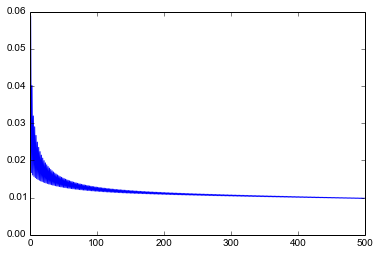

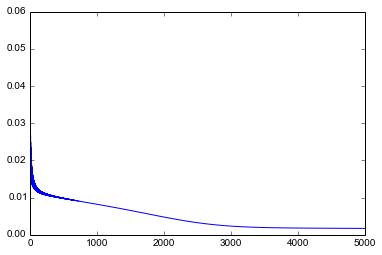

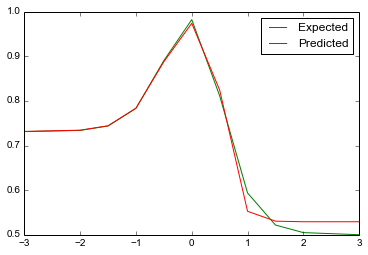

In [12]:
print "Looking for a good seed"
while True:
    W0 = (20 * np.random.uniform(size=W_mask.shape) - 10) * W_mask
    W_trained, errors = train_neural_network(W_mask, W0, xs, ys) 
    
    print ".",
    if errors[-1] < .05:
        print
        break
    

W_trained, errors = train_neural_network(W_mask, W_trained, xs, ys, 5000) 
predicted_ys = np.array([evaluate_neural_network(W_trained, x)[1][0]  for x in xs])

print
print "The weight of the trained network is"
print W_trained
print "Error: ", errors[-1]
plt.plot(np.arange(500), errors[:500])
plt.show()
plt.plot(np.arange(len(errors)), errors)
plt.show()
plt.plot(xs, ys, 'g-', label='Expected')
plt.plot(xs, predicted_ys, 'r-', label='Predicted')
plt.legend()
plt.show()

# Bird classification using Caffe

We initialize Caffe to use the AlexNet model, making sure it is downloaded and defining a transformer to transform the data in the format expected by the network.

We also load the labels from the ILSVRC 2012 dataset, where the network is trained on.

In [15]:
if not os.path.isfile(caffe_root + 'models/bvlc_alexnet/bvlc_alexnet.caffemodel'):
    print("Downloading pre-trained AlexNet model...")
    !caffe/scripts/download_model_binary.py caffe/models/bvlc_alexnet

caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'models/bvlc_alexnet/deploy.prototxt',
                caffe_root + 'models/bvlc_alexnet/bvlc_alexnet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

The [birds dataset](http://www-cvr.ai.uiuc.edu/ponce_grp/data/) is assumed to have all the images stored under birds\_data. We read it and feed it to AlexNet

In [16]:
label_dict = {'egr': 'Egret', 'man': 'Mandarin', 'owl': 'Owl', 'puf': 'Puffin', 'tou': 'Toucan', 'wod': 'Wood duck'}
label_dict_inv = {'Egret': 'egr', 'Mandarin': 'man', 'Owl': 'owl', 'Puffin': 'puf', 'Toucan': 'tou', 'Wood duck': 'wod'}

In [18]:
n_bird_images = 600
net.blobs['data'].reshape(n_bird_images,3,227,227)

bird_labels = []
image_position = {}
for i, filename in enumerate(os.listdir('birds_data')):
    if i >= n_bird_images:
        break
    image_position[filename] = i
    bird_labels.append(label_dict[filename[:3]])
    net.blobs['data'].data[i] = transformer.preprocess('data', caffe.io.load_image('birds_data/' + filename))

In [19]:
out = net.forward()

# Select the top 10 labels
top_labels = np.sum(out['prob'], axis=0).argsort()[-1:-11:-1]
top_labels_inv = {}
for i, label in enumerate(top_labels):
    top_labels_inv[label] = i

# Filter the labels not in the top 10
filter_out = np.ones(out['prob'].shape[1], dtype=bool)
filter_out[top_labels] = False

# Find how many times each bird was classified under each label
label_count = {}
for i in range(n_bird_images):
    if bird_labels[i] not in label_count:
        label_count[bird_labels[i]] = np.zeros(10, dtype=int)
    out['prob'][i][filter_out] = 0
    label_count[bird_labels[i]][top_labels_inv[out['prob'][i].argmax()]] += 1    

In [20]:
print "The top ten label indexes in descending order are", top_labels, "whose respective labels are shown below"
print
print_table(top_labels, ['Name'], labels[top_labels].reshape(-1, 1))
print
print
print "The confusion matrix is as below"
print
print_table(label_count.keys(), top_labels, label_count.values())

The top ten label indexes in descending order are [ 97  96 132  81  99 143 129 146  21  87] whose respective labels are shown below

    Name
97  n01847000 drake
96  n01843383 toucan
132 n02009912 American egret, great white heron, Egretta albus
81  n01796340 ptarmigan
99  n01855672 goose
143 n02037110 oystercatcher, oyster catcher
129 n02006656 spoonbill
146 n02058221 albatross, mollymawk
21  n01608432 kite
87  n01817953 African grey, African gray, Psittacus erithacus


The confusion matrix is as below

           97  96 132  81  99 143 129 146  21  87
Egret       0   0  87   0   1   0  10   1   1   0
Owl         0   0   0  44   3   0   0   1  23  29
Puffin     16  14   0   2  21  23   1  15   6   2
Toucan      0  99   0   0   0   0   0   0   1   0
Mandarin   89   1   0   1   3   3   2   1   0   0
Wood duck  98   0   0   0   0   2   0   0   0   0


We can see that Egrets are mostly correctly classified, sometimes being mistaken for Spoonbills, and that Toucans are almost perfectly classified as such. 

The Mandarin and Wood ducks are both classified Drakes, which are also Ducks, this might indicate that neither Mandarins nor Wood ducks were present in the data on which AlexNet was trained, so that Drake ducks are the likeliest choice. 

Puffins and Owls are dispersely classified, and the top result for Owls are Ptarmigans. The ImageNet dataset features only Great Grey Owls, while the birds dataset features mostly white owls, so that Ptarmigans being white appear to be a reasonable alternative.

We now train a linear classifier on the dataset, using the partition described in _birds_f_numbers.txt_ using both the 'fc6' and the 'fc7' layer of AlexNet.
We begin by parsing the txt file and partitioning the dataset.

In [21]:
partition_by_labels = {}
with open('birds_f_numbers.txt') as fin:
    current_count = 0
    current_bird = None
    current_bird_prefix = None
    for line in fin:
        line = ' '.join(line.split())
        if line in label_dict_inv:
            current_bird = line
            current_bird_prefix = label_dict_inv[current_bird]
            partition_by_labels[current_bird] = [[], [], []]
            current_count = 0
        try:
            image_num = str(int(line)).rjust(3, '0')
            current_count += 1
            if current_count <= 20:
                partition_by_labels[current_bird][0].append(current_bird_prefix + image_num + '.jpg')
                train_labels.append(current_bird)
            elif current_count <= 50:
                partition_by_labels[current_bird][1].append(current_bird_prefix + image_num + '.jpg')
                validation_labels.append(current_bird)
            else:
                partition_by_labels[current_bird][2].append(current_bird_prefix + image_num + '.jpg')
                test_labels.append(current_bird)
        except:
            pass


train, validate, test = map(lambda x: sum(x, []), zip(*partition_by_labels.values()))

train_labels = map(lambda img: label_dict[img[:3]], train)
validate_labels = map(lambda img: label_dict[img[:3]], validate)
test_labels = map(lambda img: label_dict[img[:3]], test)

We proceed to extract the features learned by AlexNet in the 'fc6' and 'fc7' layers for each image. Then we train a LogisticRegression model on the train portion and evaluate it in the test portion.

In [22]:
extract_features = lambda partition, layer: np.array(map(lambda img: net.blobs[layer].data[image_position[img]], partition))

train_fc6 = extract_features(train, 'fc6')
# validate_fc6 = extract_features(validate, 'fc6')
test_fc6 = extract_features(test, 'fc6')

log_reg_fc6 = LogisticRegression(dual=True).fit(train_fc6, train_labels)

# print log_reg_fc6.score(validate_fc6, validate_labels)
print "The accuracy for LogisticRegression using the 'fc6' layer is"
print log_reg_fc6.score(test_fc6, test_labels)

print

train_fc7 = extract_features(train, 'fc7')
# validate_fc7 = extract_features(validate, 'fc7')
test_fc7 = extract_features(test, 'fc7')

log_reg_fc7 = LogisticRegression(dual=True).fit(train_fc7, train_labels)

# print log_reg_fc7.score(validate_fc7, validate_labels)
print "The accuracy for LogisticRegression using the 'fc7' layer is"
print log_reg_fc7.score(test_fc7, test_labels)

The accuracy for LogisticRegression using the 'fc6' layer is
0.97

The accuracy for LogisticRegression using the 'fc7' layer is
0.966666666667


We define an auxiliary function to build the confusion matrix for both layers, and show them below.

In [23]:
def build_confusion_matrix(expected, predicted, expected_labelset, predicted_labelset):
    rows = list(expected_labelset)
    cols = list(predicted_labelset)
    confusion = np.zeros((len(rows), len(cols)), dtype=int)
    for expe, pred in zip(expected, predicted):
        confusion[rows.index(expe)][cols.index(pred)] += 1
    return rows, cols, confusion


print "For the 'fc6' layer the confusion matrix is"
print
print_table(*build_confusion_matrix(test_labels, log_reg_fc6.predict(test_fc6), label_dict_inv, label_dict_inv))
print
print
print "For the 'fc7' layer the confusion matrix is"
print
print_table(*build_confusion_matrix(test_labels, log_reg_fc7.predict(test_fc7), label_dict_inv, label_dict_inv))
        

For the 'fc6' layer the confusion matrix is

              Egret       Owl    Puffin    Toucan  Mandarin Wood duck
Egret            49         0         1         0         0         0
Owl               0        50         0         0         0         0
Puffin            0         0        50         0         0         0
Toucan            0         0         0        49         0         1
Mandarin          0         0         3         1        45         1
Wood duck         0         0         1         0         1        48


For the 'fc7' layer the confusion matrix is

              Egret       Owl    Puffin    Toucan  Mandarin Wood duck
Egret            50         0         0         0         0         0
Owl               0        50         0         0         0         0
Puffin            0         0        50         0         0         0
Toucan            0         0         0        50         0         0
Mandarin          0         0         5         1        42         

Even with no parameter tuning, and a using only 20% of the data for training, both layers achieve a high score, classifying perfectly all birds except the Mandarin and the Wood Duck, which are slightly confounded. The 'fc7' layer performs worse than the 'fc6' layer when classifying Mandarin ducks and Wood ducks, confounding between them and with Puffins too.

This seems to indicate that the features learned by the 'fc7' layer are not properly trained to classify these, and that fine tuning should be used to improve them, or the layer discarded.

In [24]:
train_fc6 = extract_features(train + validate, 'fc6')
test_fc6 = extract_features(test, 'fc6')

log_reg_fc6 = LogisticRegression(dual=True).fit(train_fc6, train_labels + validate_labels)

# print log_reg_fc6.score(validate_fc6, validate_labels)
print "The accuracy for LogisticRegression using the 'fc6' layer is"
print log_reg_fc6.score(test_fc6, test_labels)

train_fc7 = extract_features(train + validate, 'fc7')
test_fc7 = extract_features(test, 'fc7')

print

log_reg_fc7 = LogisticRegression(dual=True).fit(train_fc7, train_labels + validate_labels)

# print log_reg_fc7.score(validate_fc7, validate_labels)
print "The accuracy for LogisticRegression using the 'fc7' layer is"
print log_reg_fc7.score(test_fc7, test_labels)

print
print

print "For the 'fc6' layer the confusion matrix is"
print
print_table(*build_confusion_matrix(test_labels, log_reg_fc6.predict(test_fc6), label_dict_inv, label_dict_inv))
print
print
print "For the 'fc7' layer the confusion matrix is"
print
print_table(*build_confusion_matrix(test_labels, log_reg_fc7.predict(test_fc7), label_dict_inv, label_dict_inv))

The accuracy for LogisticRegression using the 'fc6' layer is
0.986666666667

The accuracy for LogisticRegression using the 'fc7' layer is
0.976666666667


For the 'fc6' layer the confusion matrix is

              Egret       Owl    Puffin    Toucan  Mandarin Wood duck
Egret            50         0         0         0         0         0
Owl               0        50         0         0         0         0
Puffin            0         0        50         0         0         0
Toucan            0         0         0        50         0         0
Mandarin          0         0         2         0        48         0
Wood duck         0         0         1         0         1        48


For the 'fc7' layer the confusion matrix is

              Egret       Owl    Puffin    Toucan  Mandarin Wood duck
Egret            50         0         0         0         0         0
Owl               0        50         0         0         0         0
Puffin            0         0        50         0    

Using both the validation and test partitions as test, the accuracy improves as expected, and we see that 'fc6' is still sligthly better than 'fc7', the latter still being slightly worse differentiating between Mandarins and Puffins and Mandarins and Wood ducks.

# RICA Autoencoder

The RICA is an unsupervised algorithm that aims to extract features from a set of data.

The cost function is given by 
$$\underset{W}{\min} \lambda\Vert W x \Vert_1 + \frac{1}{2}\Vert W^T W x - x\Vert_2^2$$

We can compare it with the cost function with the autoencoder, which is given by
$$\underset{W}{\min} \lambda\Vert \sigma(W x) \Vert_1 + \frac{1}{2}\left\Vert \sigma\left(W^T\sigma(W x)\right) - x\right\Vert_2^2$$

So that RICA can be understood as an autoencoder with a linear activation function.

The implementation for the autoencoder available in https://github.com/jatinshah/ufldl_tutorial/blob/master/train.py was run to look for 49 features over the first 10.000 images from the MNIST dataset, and the learned representation is shown below.
The features learned seem to be strokes, but it's still possible to guess what digit they represent.

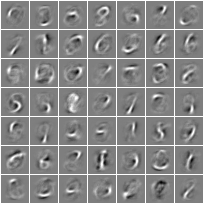

In [25]:
display(Image('autoencoder.png'))

Below we implement the RICA cost function as well as it's gradient to perform gradient descent.

In [26]:
def RICA_iteration(W, x, n, N, batch_size, lambda_param=1, epsilon=0.01):
    # x is a batch of batch_size N-dimensional vectors (N x batch_size)
    # W is a n x N matrix
    
    W = W.reshape(n, N)
    x = x.reshape(N, batch_size)
    
    reconstruction = np.dot(np.dot(W.T, W), x) - x       
    regularization = np.sqrt(np.dot(W, x)**2 + epsilon)
    
    # RICA cost
    regularization_cost = lambda_param * np.sum(regularization) 
    reconstruction_cost = .5 * squared_l2(reconstruction)
    RICA_cost = (regularization_cost + reconstruction_cost) / batch_size

    # RICA gradient
    regularization_gradient = lambda_param * np.dot(np.dot(W, x) / regularization, x.T)
    reconstruction_gradient_W = np.dot(np.dot(W, reconstruction), x.T)    # Gradient w.r.t. W
    reconstruction_gradient_W_T = np.dot(np.dot(W, x), reconstruction.T)  # Gradient w.r.t. W.T
    RICA_gradient = (regularization_gradient + reconstruction_gradient_W + reconstruction_gradient_W_T) / batch_size
    
    return RICA_cost, RICA_gradient.flatten()

def RICA_iteration_test():
    n = 30
    N = 100
    batch_size = 15
    
    W0 = np.random.uniform(size = n * N)
    x = np.random.uniform(size = (N, batch_size))
    
    _, dW0 = RICA_iteration(W0, x, n, N, batch_size)
    
    cost = lambda W: RICA_iteration(W, x, n, N, batch_size)
    numerical_dW0 = compute_gradient(cost, W0)
    
    worst = 0
    for i in range(n * N):
        worst = max(worst, relative_error(dW0[i], numerical_dW0[i]))
    assert worst < 1e-6

RICA_iteration_test()

We read the images from MNIST and select 10.000 to train RICA on.

In [29]:
n = 7 * 7
N = 28 * 28
batch_size = 10000

images = load_MNIST_images('train-images-idx3-ubyte')
patches = images[:, :batch_size]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


And train the RICA model using a random seed.

original cost: 44.0089556764
cost after optimization: 4.62099869418


/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:178: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:178: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


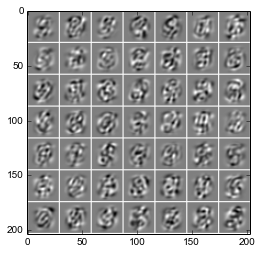

In [31]:
RICA = lambda W: RICA_iteration(W, patches, n, N, batch_size, lambda_param=3e-6)

# Random seed on the [-r, r] interval
# This was so in the autoencoder program, so is kept for better comparison
r = np.sqrt(6) / np.sqrt(n + N + 1)
W0 = 2*r * np.random.uniform(size = n * N) - r

original_cost = RICA(W0)[0]

result = opt.minimize(RICA, W0, jac=True, method='L-BFGS-B', options={'maxiter': 1000, 'disp': True})
W_sol = result.x.reshape(n, N)

optimized_cost = RICA(W_sol)[0]

print "original cost:", original_cost
print "cost after optimization:", optimized_cost

display_network(W_sol.T)

We can see that the features learned are much noisier and can't be easily interpreted as being strokes.